# Demonstration notebook for evaluation and results
This is a self contained notebook with intermediate files generated to aid the evaluation process.

The models are trained and uploaded to huggingface, and loaded in the notebook.

5000 poems are generated using the RL and the baseline model.

The evaluation process for sentiment accuracy (30min) and fluency can be a little slow depending on the computing power.


# Imports

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers datasets language_tool_python scipy matplotlib numpy pandas torch

In [17]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import numpy as np
import pandas as pd
import torch
from itertools import compress
import language_tool_python
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer, pipeline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda")

# Helper functions

In [5]:
def load_evaluation_prompts(length=5, seed=19019509):
    """
    load one prompt from each emotion
    length:  length of the prompt
    """
    PERC_path = "./PERC.csv"
    rng = np.random.default_rng(seed)
    dataset = pd.read_csv(PERC_path)
    Emotions = list(set(dataset['Emotion']))
    Emotions.sort()
    Prompts = {}
    for emotion in Emotions:
        mask = dataset["Emotion"] == emotion
        prompt = rng.choice(dataset[mask])[0]
        Prompts[emotion] = ' '.join(prompt.split()[:length])
    return Prompts

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [18]:
def generation(tokenizer, model, encoded_prompt, save_path, iteration=20):
    """
    generate 5000 texts to file with baseline model
    """
    generation_length = 100
    f = open(save_path, "a", encoding="utf-8")
    for i in range(iteration):
        print(i+1, "/", iteration)
        set_seed(i)
        generation_kwargs = {
            "max_length": generation_length + len(encoded_prompt[0]),
            "top_k": 50,
            "num_return_sequences": 250,
            "top_p": 0.9,
            "do_sample": True,
            "repetition_penalty": 1.0
        }
        output_sequences = model.generate(input_ids=encoded_prompt, **generation_kwargs)
        if len(output_sequences.shape) > 2:
                output_sequences.squeeze_()

        generated_sequences = []

        for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
            f.write(f"\n=== GENERATED SEQUENCE {generated_sequence_idx + 1} ===\n")
            generated_sequence = generated_sequence.tolist()

            # Decode text
            text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

            # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
            total_sequence = (
                joy + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]
            )

            generated_sequences.append(total_sequence)
            f.write(total_sequence)
    f.close()

In [21]:
def _read_text(path):
    """
    read in the generated text and remove excess
    """
    with open(path, encoding="utf8") as f:
        lines = [line.strip() for line in f]

    phrases = []
    phrase = ""
    for x in lines:
        if x.startswith("==="):
            phrases.append(phrase)
            phrase = ""
            continue
        phrase = phrase + x
    return phrases

def fluency(path = "./baseline_generation.txt", verbose = 0, size=None):
    """
    Give a score on the average fluency and fluency distribution

    Returns:
            error rate: single float over all phrases
            error rates: array of float for each phrase
    """
    phrases = _read_text(path)
    rng = np.random.default_rng()
    if size != None:
        indices = rng.choice(len(phrases), size)
        phrases = [phrases[index] for index in indices]
    print(len(phrases), " phrases")

    # mask = [not x.startswith("===") for x in lines]
    # sentences = list(compress(lines, mask))   
    # check grammar error rate from the language tool
    tool = language_tool_python.LanguageTool("en-US")
    total_length = 0
    total_errors = 0
    error_rate = 0
    error_rates = []
    counter = 0
    for phrase in phrases:
        try:
            if verbose >= 1:
                counter += 1
                print(counter)
            length = len(phrase.split())
            total_length += length
            matches = tool.check(phrase)
            error_counter = 0
            for i in matches:
                if i.ruleId == "WHITESPACE_RULE" or i.ruleId == "PRP_COMMA" or i.ruleId == "COMMA_COMPOUND_SENTENCE":
                    continue
                error_counter += 1
            naive_errors = error_counter
            total_errors += naive_errors
            if length > 0:
                error_rates.append(1-naive_errors/length)
        except KeyboardInterrupt:
            break
    tool.close()
    error_rate = 1-total_errors/total_length
    return error_rate, error_rates

def diversity(path = "./baseline_generation.txt", seed=None, size = 50):
    """
    Diversity between {size} phrases
    path: the path of the generated txt file containing the phrases
    seed: for reproducibility
    """
    tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model.to(device)
    # Tokenize input texts
    texts = _read_text(path=path)
    rng = np.random.default_rng()
    if seed != None:
        rng = np.random.default_rng(seed=seed)
    indices = rng.choice(len(texts), size=size, replace=False)
    print("selecting indices: ", indices)
    texts = [texts[index] for index in indices]

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs.to(device)
    # Get the embeddings
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.cpu()

    # Calculate cosine similarities
    # results are in [0, 1]. Higher means more diversity
    cos_sim_mat = []
    for i in range(embeddings.shape[0]):
        print(i+1, "/", size)
        for j in range(embeddings.shape[0]):
            if i >= j:
                continue
            cos_sim = cosine(embeddings[i], embeddings[j])/2
            cos_sim_mat.append(cos_sim)
    return cos_sim_mat

def accuracy_smooth(path = "./baseline_generation.txt", size = None, metric=1):
    """
    Calculate the sentiment accuracy score for a generation file
    """
    phrases = _read_text(path)
    rng = np.random.default_rng()
    if size != None:
        indices = rng.choice(len(phrases), size)
        phrases = [phrases[index] for index in indices]
    print(len(phrases), " phrases")
    model = 'cardiffnlp/twitter-roberta-base-sentiment' if metric == 1 else 'nickwong64/bert-base-uncased-poems-sentiment'
    nlp = pipeline(task='text-classification', model=model, top_k=None)
    results = nlp(phrases)
    scores = [labels['score'] for result in results for labels in result if labels['label'] == 'LABEL_2']
    neg_scores = [labels['score'] for result in results for labels in result if labels['label'] == 'LABEL_0']
    return scores, neg_scores

def novelty_new(training_phrase, path = "./baseline_generation.txt", seed=None, size = 50, start=None, prompt_size=5):
    """
    Novelty between {size} phrases and the trainning phrase
    training_phrase: the phrase used in the training dataset with the same prompt as the generated phrases
    path: the path of the generated txt file containing the phrases
    seed: for reproducibility
    start: select in order, seed is not used if start != None
    """
    tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
    model.to(device)
    # Tokenize input texts
    texts = _read_text(path=path)
    if start == None:
        rng = np.random.default_rng()
        if seed != None:
            rng = np.random.default_rng(seed=seed)
        index = rng.choice(len(texts))
    else:
        index = start if start+size < len(texts) else 0
    texts = texts[index:index+size]
    texts.append(training_phrase)
    texts = [' '.join(text.split()[5:]) for text in texts]

    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs.to(device)
    # Get the embeddings
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.cpu()

    # Calculate cosine similarities
    # results are in [0, 1]. Higher means more diversity
    cos_sim_mat = []
    for i in range(embeddings.shape[0]-1):
            cos_sim = cosine(embeddings[i], embeddings[-1])/2
            cos_sim_mat.append(cos_sim)
    return cos_sim_mat


# Data

In [8]:
data_name = "COMP0087-GROUP8-22-23/PERC"
PERC_path = "./PERC.csv"
dataset = load_dataset(data_name)
data = dataset['train']
data.to_csv(PERC_path)
print(list(set(data['Emotion'])))

  0%|          | 0/1 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

['fear', 'surprise', 'sad', 'joy', 'peace', 'love', 'hate', 'anger', 'courage']


In [9]:
set_seed(0)
prompts = load_evaluation_prompts(seed=1234567)
joy = prompts["joy"]
# this is for novelty evaluation
original = load_evaluation_prompts(seed=1234567, length=-1)
joy_original = original["joy"]
print("Using prompt: ", joy, " original sentence: \n", joy_original)

Using prompt:  To My Fairy Fancies NAY,  original sentence: 
 To My Fairy Fancies NAY, no longer I may hold you, In my spirit's soft caresses, Nor like lotus-leaves enfold you In the tangles of my tresses. Fairy fancies, fly away To the white cloud-wildernesses, Fly away! Nay, no longer ye may linger With your laughter-lighted faces, Now I am a thought-worn singer In life's high and lonely places. Fairy fancies, fly away, To bright wind-inwoven spaces, Fly


# Baseline generation
Look at file "./baseline_generation.txt" for other examples of generated text

In [10]:
model_name = "COMP0087-GROUP8-22-23/GPT2-poem-baseline"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
encoded_prompt = tokenizer.encode(joy, add_special_tokens=False, return_tensors="pt")
encoded_prompt = encoded_prompt.to(device)

In [ ]:
generation(tokenizer=tokenizer, model=model, encoded_prompt=encoded_prompt, save_path="./baseline_generation.txt", iteration=20)


# Baseline evaluation

## Sentiment accuracy

5000  phrases
0.4102119948732201 0.2796032066606219


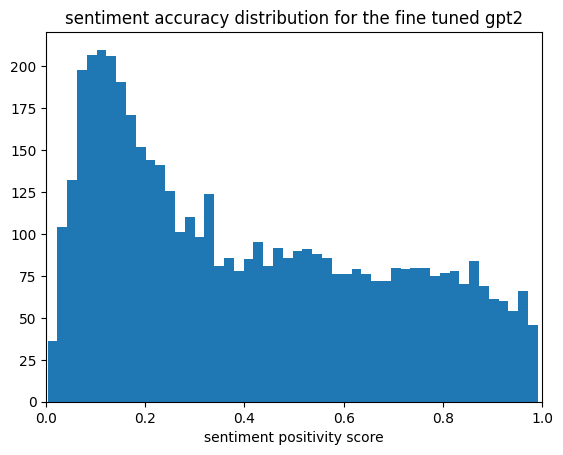

In [22]:
pos_score, neg_score = accuracy_smooth()
print(np.mean(pos_score), np.std(pos_score))
plt.figure()
plt.hist(pos_score, bins=50)
plt.title("sentiment accuracy distribution for the fine tuned gpt2")
plt.xlim(0, 1)
plt.xlabel("sentiment positivity score")
plt.show()

## Diversity

selecting indices:  [2296 3108 3992 1156 1804 1824 3887 3244 2033 3369 1623 4782 3815  214
 1395 1970 2107 1490 1556 3324 4258 1216 4868 3595 1068 1206 4518 2993
 4038  774 4859 3675 4021 3125 1867 2873 3811 2003 1205 1344 3825 4198
 4838 3630  862 3774 2112 4612 1891  832 1109 1957 1708 3725 3237 2431
 3285 1487 2235 3017 4216 4027 2199 2930 2025 2707 2070 1248  840  414
  679  742  470  142 3010 1923 4420 3410 3788  205  978 2803 3028 3297
  199 3321 3904 4449 4222 1112 2696 2016 2979 2417 3664   38 1996 3728
 2457 2286]
0.3203146090805754 0.06374603863836215


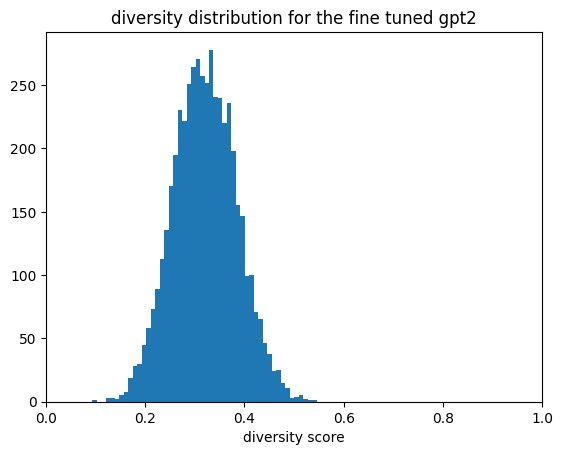

In [57]:
diversity_score = diversity(size=100)
print(np.mean(diversity_score), np.std(diversity_score))
plt.figure()
plt.hist(diversity_score, bins=50)
plt.title("diversity distribution for the fine tuned gpt2")
plt.xlabel("diversity score")
plt.xlim(0, 1)
plt.show()

## Novelty
If there is a memory error, change size to smaller value

In [25]:
size = 500
novelty_score = []
for i in range(int(5000/size)):
    print(i+1, "/", int(5000/size))
    novelty_score.append(novelty_new(training_phrase=joy_original, size=size, start=i*size))
    
np.savetxt('./baseline_novelty_scores.txt', novelty_score, delimiter=',') 

0
1
2
3
4
5
6
7
8
9


0.35949116676701814 0.05785492058752394


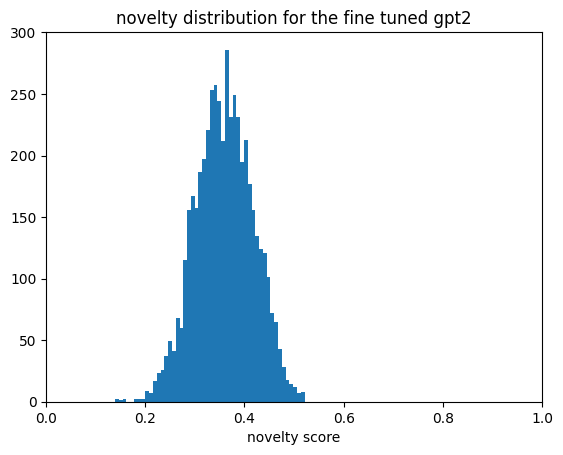

In [26]:
loaded_novelty = np.loadtxt('./baseline_novelty_scores.txt', delimiter=',') 
loaded_novelty = loaded_novelty.flatten()
loaded_novelty.shape
print(np.mean(loaded_novelty), np.std(loaded_novelty))
plt.figure()
plt.hist(loaded_novelty, bins=50)
plt.title("novelty distribution for the fine tuned gpt2")
plt.xlabel("novelty score")
plt.xlim(0,1)
plt.show()

## Fluency

In [ ]:
print("please wait until 5000 phrases are analyzed, colab is slow for fluency evaluation")
rate, rates = fluency(verbose=1)
print(np.mean(rates), np.std(rates))
plt.close()
plt.figure()
plt.hist(rates, bins=50)
plt.title("fluency distribution for the fine tuned gpt2")
plt.xlabel("fluency score")
plt.xlim(0, 1)
plt.show()

# RL generation

In [ ]:
model_name = "COMP0087-GROUP8-22-23/GPT2-poem-baseline"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
encoded_prompt = tokenizer.encode(joy, add_special_tokens=False, return_tensors="pt")
encoded_prompt = encoded_prompt.to(device)

In [ ]:
generation(tokenizer=tokenizer, model=model, encoded_prompt=encoded_prompt, save_path="./rl_generation.txt", iteration=20)

# RL evaluation

## Sentiment accuracy

In [ ]:
pos_score, neg_score = accuracy_smooth(path="./rl_generation.txt")
print(np.mean(pos_score), np.std(pos_score))
plt.figure()
plt.hist(pos_score, bins=50)
plt.title("sentiment accuracy distribution for the fine tuned gpt2")
plt.xlim(0, 1)
plt.xlabel("sentiment positivity score")
plt.show()

## Diversity

In [ ]:
diversity_score = diversity(path="./rl_generation.txt", size=100)
print(np.mean(diversity_score), np.std(diversity_score))
plt.figure()
plt.hist(diversity_score, bins=50)
plt.title("diversity distribution for the fine tuned gpt2")
plt.xlabel("diversity score")
plt.xlim(0, 1)
plt.show()

## Novelty

In [ ]:
novelty_score = []
for i in range(25):
    print(i)
    novelty_score.append(novelty_new(path="./rl_generation.txt", training_phrase=joy_original, size=200, start=i*200))
    
np.savetxt('./rl_novelty_scores.txt', novelty_score, delimiter=',') 

In [ ]:
loaded_novelty = np.loadtxt('./rl_novelty_scores.txt', delimiter=',') 
loaded_novelty = loaded_novelty.flatten()
loaded_novelty.shape
print(np.mean(loaded_novelty), np.std(loaded_novelty))
plt.figure()
plt.hist(loaded_novelty, bins=50)
plt.title("novelty distribution for the fine tuned gpt2")
plt.xlabel("novelty score")
plt.xlim(0,1)
plt.show()

## Fluency

In [ ]:
print("please wait until 5000 phrases are analyzed, colab is slow for fluency evaluation")
rate, rates = fluency(path="./rl_generation.txt", verbose=1)
print(np.mean(rates), np.std(rates))
plt.close()
plt.figure()
plt.hist(rates, bins=50)
plt.title("fluency distribution for the fine tuned gpt2")
plt.xlabel("fluency score")
plt.xlim(0, 1)
plt.show()